In [1]:
# Auto-reload modules
%load_ext autoreload
%autoreload 2


In [2]:
# independent project
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import data

from data.gen_sample_ab import generate_ab_data, generate_skewed_ab_data, plot_ab_distributions


In [3]:
from utils.utils_ab_test import calculate_ratio_confidence_intervals

In [4]:
df = generate_skewed_ab_data(
    n_samples=10000,
    mean_control=2,  # mean parameter for log-normal distribution
    mean_treatment=2.5,  # mean parameter for treatment group
    sigma=10,  # standard deviation parameter for log-normal
    zero_prob_control=0.1,  # probability of zeros in control group
    zero_prob_treatment=0.1,  # probability of zeros in treatment group
    random_state=42,
    lower_bound=0,
    upper_bound=5000
)
plot_ab_distributions(df)
df.groupby('group').agg({'value': ['mean', 'std', 'size']})


TypeError: generate_skewed_ab_data() got an unexpected keyword argument 'lower_bound'

In [19]:
df.sort_values(by='value')

,user_id,group,value
18212,18212,treatment,0.000000e+00
13476,13476,treatment,0.000000e+00
13475,13475,treatment,0.000000e+00
18255,18255,treatment,0.000000e+00
10586,10586,treatment,0.000000e+00
...,...,...,...
17048,17048,treatment,5.380540e+16
12780,12780,treatment,1.312979e+17
17548,17548,treatment,1.885866e+17
3079,3079,control,9.770460e+17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


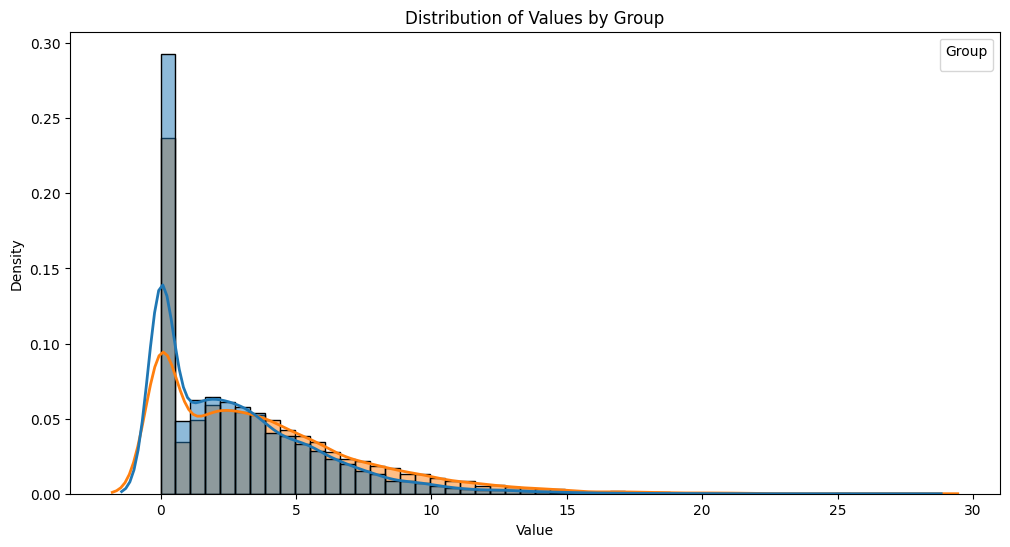

Relative difference: 0.3384
Standard error: 0.0197
95% Confidence Interval: (0.2993, 0.3774)
Ratio (Treatment/Control): 1.3383692882377212

Confidence Intervals (95%):
Delta Method: (1.2997, 1.3771)
Bootstrap: (1.2974, 1.3743)
Monte Carlo: (1.3005, 1.3769)


In [20]:

    
    # Visualize the distributions


results = calculate_relative_difference(df,'value','group')
print(f"Relative difference: {results['relative_diff']:.4f}")
print(f"Standard error: {results['std_error']:.4f}")
print(f"95% Confidence Interval: ({results['ci_lower']:.4f}, {results['ci_upper']:.4f})")



# Example using the AB test data
treatment_data = df[df['group'] == 'treatment']['value']
control_data = df[df['group'] == 'control']['value']

# Calculate statistics
treatment_mean = treatment_data.mean()
control_mean = control_data.mean()
treatment_std = treatment_data.std()
control_std = control_data.std()
n_treatment = len(treatment_data)
n_control = len(control_data)

# Calculate CIs using all three methods
delta_ci = delta_method_ci(
    treatment_mean, control_mean,
    treatment_std, control_std,
    n_treatment, n_control
)

bootstrap_ci_result = bootstrap_ci(
    treatment_data, control_data
)

monte_carlo_ci_result = monte_carlo_ci(
    treatment_mean, control_mean,
    treatment_std, control_std,
    n_treatment, n_control
)

print("Ratio (Treatment/Control):", treatment_mean/control_mean)
print("\nConfidence Intervals (95%):")
print(f"Delta Method: ({delta_ci[0]:.4f}, {delta_ci[1]:.4f})")
print(f"Bootstrap: ({bootstrap_ci_result[0]:.4f}, {bootstrap_ci_result[1]:.4f})")
print(f"Monte Carlo: ({monte_carlo_ci_result[0]:.4f}, {monte_carlo_ci_result[1]:.4f})")

In [10]:
df

,user_id,group,value
0,0,control,32.626121
1,1,control,44.763028
2,2,control,56.559039
3,3,control,38.204141
4,4,control,0.000000
...,...,...,...
19995,19995,treatment,36.564556
19996,19996,treatment,0.000000
19997,19997,treatment,58.456664
19998,19998,treatment,60.158958


In [34]:
params = {
    'n_samples': 10000,
    'control_param': 0.1,
    'treatment_effect': 0.05,
    'std': 15,
    'random_state': 42,
    'data_type': 'binary'
}
df = generate_ab_data(**params)
print("\nSimulation parameters:")
for param, value in params.items():
    print(f"{param}: {value}")


Simulation parameters:
n_samples: 10000
control_param: 0.1
treatment_effect: 0.05
std: 15
random_state: 42
data_type: binary


In [35]:
df.head(1)

,user_id,group,converted
0,0,control,0


In [36]:
df.groupby('group').agg({'converted': ['mean', 'std', 'size']})

converted                 
               mean       std   size
group                               
control      0.0961  0.294743  10000
treatment    0.1566  0.363441  10000

In [12]:
import numpy as np
def calculate_relative_difference(df, value_col='converted', group_col='group', confidence_level=0.95):
    """
    Calculate relative difference between control and treatment groups using delta method
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing A/B test data
    value_col : str
        Name of column containing metric values
    group_col : str 
        Name of column containing group labels
    confidence_level : float
        Confidence level for interval calculation (default 0.95)
        
    Returns:
    --------
    dict : Dictionary containing:
        - relative_diff: Relative difference between treatment and control
        - std_error: Standard error of the relative difference
        - ci_lower: Lower bound of confidence interval
        - ci_upper: Upper bound of confidence interval
    """
    # Get means for each group
    control_mean = df[df[group_col]=='control'][value_col].mean()
    treatment_mean = df[df[group_col]=='treatment'][value_col].mean()
    
    # Get standard errors for each group
    control_se = df[df[group_col]=='control'][value_col].std() / np.sqrt(len(df[df[group_col]=='control']))
    treatment_se = df[df[group_col]=='treatment'][value_col].std() / np.sqrt(len(df[df[group_col]=='treatment']))
    
    # Calculate relative difference
    relative_diff = (treatment_mean - control_mean) / control_mean
    
    # Calculate standard error using delta method
    std_error = np.sqrt((treatment_se/control_mean)**2 + 
                       (treatment_mean * control_se/control_mean**2)**2)
    
    # Calculate confidence interval
    z_score = abs(np.percentile(np.random.standard_normal(10000), (1 - confidence_level) / 2 * 100))
    margin_of_error = z_score * std_error
    ci_lower = relative_diff - margin_of_error
    ci_upper = relative_diff + margin_of_error
    
    return {
        'relative_diff': relative_diff,
        'std_error': std_error,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Calculate and display relative difference with confidence interval
results = calculate_relative_difference(df)
print(f"Relative difference: {results['relative_diff']:.4f}")
print(f"Standard error: {results['std_error']:.4f}")
print(f"95% Confidence Interval: ({results['ci_lower']:.4f}, {results['ci_upper']:.4f})")

KeyError: 'converted'

In [ ]:
# The ratio of two normal distributions follows a Cauchy distribution if the denominator's mean is non-zero.
# However, this is only true under certain conditions:
# 1. The variables must be independent
# 2. The denominator must not be close to zero (to avoid division by zero issues)
# 3. The denominator should have small variance relative to its mean

# For example, if:
# a ~ N(μ₁, σ₁²)
# b ~ N(μ₂, σ₂²)
# Then a/b follows a ratio distribution that can be approximated by a Cauchy distribution
# when σ₂ is small relative to μ₂

# The exact PDF is complex and involves Bessel functions. In practice, it's often
# better to use:
# 1. Delta method approximation
# 2. Bootstrap sampling
# 3. Numerical methods
